In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime as dt
from pandas_datareader import DataReader as DR
import seaborn as sb
import numdifftools as nd
from wquantiles import quantile
import statsmodels.api as sm

from scipy.stats import norm,t,truncnorm
from scipy.stats import multivariate_normal as mvnorm
from scipy.stats import multivariate_t as mvt
from scipy.spatial import Delaunay as TRI
from scipy.interpolate import LinearNDInterpolator as ITP
from scipy.optimize import minimize
from scipy.optimize import NonlinearConstraint as NonlinCons
from scipy.stats import gaussian_kde as sciKDE

from sklearn.linear_model import LinearRegression as Linear
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KernelDensity as sklKDE

import warnings
warnings.filterwarnings("ignore")

# Define the experiment class

In [2]:
class MLE:
    def __init__(self,dim,sigma):
        self.dim=dim
        self.T=lambda x: mvnorm.pdf(x=x,mean=np.zeros(dim))
        self.iP=lambda x: mvnorm.pdf(x=x,mean=np.zeros(dim),cov=sigma**2)
        self.iS=lambda size: mvnorm.rvs(size=size,mean=np.zeros(dim),cov=sigma**2)
        
    def __estimate(self,W,name,asym=True):
        Z=np.mean(W)
        err=np.abs(Z-1)
        if asym:
            aVar=np.var(W)
            aErr=np.sqrt(aVar/W.size)
            ESS=1/np.sum((W/np.sum(W))**2)
            print('{} est: {:.4f}; err: {:.4f}; a-var: {:.4f}; a-err: {:.4f}; ESS: {:.0f}'\
                  .format(name,Z,err,aVar,aErr,ESS))
        else:
            print('{} est: {:.4f}; err: {:.4f}'.format(name,Z,err))
        
    def estimate_IS(self,size):
        S=self.iS(size)
        W=self.T(S)/self.iP(S)
        self.__estimate(W,'IS')
    
    def draw_TP(self,P,x,name,dim=0):
        X=np.zeros([x.size,self.dim])
        X[:,dim]=x
        ratio=np.reshape(self.T(np.zeros(self.dim))/P(np.zeros([1,self.dim])),1)[0]
        print('------------ pdf ratio at origin: {:.2f} ------------'.format(ratio))
        
        fig,ax=plt.subplots(figsize=(7,4))
        ax.plot(x,self.T(X))
        ax.plot(x,P(X))
        if name=='nonparametric':
            one=np.zeros(self.dim)
            one[dim]=1
            rW=np.array([self.h(one*loc,loc) for loc in self.rS])
            rW=rW/rW.max()*P(np.zeros([1,self.dim]))[0]
            rWmeans=np.ones_like(rW)*rW.mean()

            ax.plot(x,self.mP(X))
            ax.hist(self.rS[:,dim],bins=2*rW.size,weights=rWmeans)
            ax.hist(self.rS[:,dim],bins=2*rW.size,weights=rW)
            ax.legend(['target','nonparametric proposal','mixture proposal','centers','centers with weight'])
        elif name=='regression':
            G=self.G(X)
            rPO=self.regO.coef_.dot(G)+self.regO.intercept_*P(X)
            rPL=self.regL.coef_.dot(G)+self.regL.intercept_*P(X)
            mid=int(x.size/2)
            print('regression ratios: ordinary {:.4f}, lasso {:.4f}'\
                  .format(self.T(X[mid])/rPO[mid],self.T(X[mid])/rPL[mid]))
            
            ax.plot(x,rPO)
            ax.plot(x,rPL)
            ax.legend(['target','mixture proposal','ordinary regression','lasso regression'])
        else:
            ax.legend(['target','{} proposal'.format(name)])
            
        ax.set_title('{}-D target and {} proposal (cross-sectional view)'.format(self.dim,name))
        plt.show()
        
    def resample(self,size,ratio):
        S=self.iS(ratio*size)
        p=self.T(S)/self.iP(S)
        index=np.arange(S.shape[0])
        choice=np.random.choice(index,size,p=p/np.sum(p),replace=True)
        
        self.rS=S[choice]
        self.rSset=S[list(set(choice))]
        print('resample rate: {}/{}'.format(self.rSset.shape[0],size))
        
    def estimate_NIS(self,size,rate,bdwth='scott'):
        if(type(bdwth)==str):
            method=bdwth
            tmp=sciKDE(self.rS.T,bw_method=method)
            bdwth=np.mean(np.sqrt(np.diag(tmp.covariance_factor()*np.cov(self.rS.T))))
            print('bdwth: {:.4f} (based on {})'.format(bdwth,method))
        
        self.bdwth=bdwth
        self.kde=sklKDE(kernel='gaussian',bandwidth=bdwth).fit(self.rS)
        self.h=lambda x,loc: mvnorm.pdf(x=x,mean=loc,cov=self.bdwth**2)
        self.G=lambda x: np.array([self.h(x,loc) for loc in self.rSset])-self.iP(x)
        
        self.nP=lambda x: np.exp(self.kde.score_samples(x))
        self.nS=lambda size: self.kde.sample(size)
        S=self.nS(size)
        W=self.T(S)/self.nP(S)
        self.__estimate(W,'NIS')
        
        self.mP=lambda x: (1-rate)*self.iP(x)+rate*self.nP(x)
        self.mS=lambda size: np.vstack([self.iS(size-round(rate*size)),self.nS(round(rate*size))])
        self.S=self.mS(size)
        W=self.T(self.S)/self.mP(self.S)
        self.__estimate(W,'MIS')
        
    def estimate_RIS(self,alpha):
        X=(self.G(self.S)/self.mP(self.S)).T
        y=self.T(self.S)/self.mP(self.S)
        self.regO=Linear().fit(X,y)
        self.regL=Lasso(alpha).fit(X,y)
        print('Ordinary R2: {:.4f}; Lasso R2: {:.4f}'.format(self.regO.score(X,y),self.regL.score(X,y)))
        
        W=y-X.dot(self.regO.coef_)
        self.__estimate(W,'RIS(Ord)')
        W=y-X.dot(self.regL.coef_)
        self.__estimate(W,'RIS(Las)')
    
    def estimate_MLE(self,opt=False):
        mP=self.mP(self.S)
        G=self.G(self.S)
        target=lambda zeta: -np.mean(np.log(mP+zeta.dot(G)))
        gradient=lambda zeta: -np.mean(G/(mP+zeta.dot(G)),axis=1)
        zeta0=np.zeros(G.shape[0])
        grad0=gradient(zeta0)
        print('Reference:')
        print('origin: value: {:.4f}; grad: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f})'\
              .format(target(zeta0),grad0.min(),grad0.mean(),grad0.max(),grad0.std()))
        
        print()
        print('Theoretical results:')
        X=(G/mP).T
        XX=X-X.mean(axis=0)
        zeta1=np.linalg.solve(XX.T.dot(XX),X.sum(axis=0))
        print('MLE(The) zeta: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f}, norm {:.4f})'\
              .format(zeta1.min(),zeta1.mean(),zeta1.max(),zeta1.std(),np.sqrt(np.sum(zeta1**2))))
        grad1=gradient(zeta1)
        print('theory: value: {:.4f}; grad: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f})'\
              .format(target(zeta1),grad1.min(),grad1.mean(),grad1.max(),grad1.std()))
        W=(self.T(self.S)/mP)*(1-XX.dot(zeta1))
        self.__estimate(W,'RIS(The)',asym=False)
        W=self.T(self.S)/(mP+zeta1.dot(G))
        self.__estimate(W,'MLE(The)',asym=False)
        
        if opt:
            if(all(mP+zeta1.dot(G)>0)):
                zeta=zeta1
            else:
                zeta=zeta0

            begin=dt.now()
            cons=({'type':'ineq','fun':lambda zeta: mP+zeta.dot(G),'jac':lambda zeta: G.T})
            res=minimize(target,zeta,method='SLSQP',jac=gradient,constraints=cons,\
                         options={'ftol':1e-10,'maxiter':1000})
            end=dt.now()
            print()
            print('Optimization results:')
            print('MLE nit: {}, spent {} seconds! '.format(res['nit'],(end-begin).seconds))
            if res['success']:
                zeta=res['x']
                print('MLE(Opt) zeta: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f}, norm {:.4f})'\
                      .format(zeta.min(),zeta.mean(),zeta.max(),zeta.std(),np.sqrt(np.sum(zeta**2))))
                print('Dist(zeta(Opt),zeta(The))={:.4f}'.format(np.sqrt(np.sum((zeta-zeta1)**2))))
                grad=gradient(zeta)
                print('optimal: value: {:.4f}; grad: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f})'\
                      .format(target(zeta),grad.min(),grad.mean(),grad.max(),grad.std()))
                W=self.T(self.S)/(mP+zeta.dot(G))
                self.__estimate(W,'MLE(Opt)',asym=False)
            else:
                print('MLE fail')

**Limitations:**
1. didn't consider self-normalized importance sampling
2. only for symmetric normal target and initial proposal with only one mode
3. only for normal KDE without weights and adaptive bandwidth
4. only consider regression for proposal components based on mixture proposal
5. not yet use gradient descent for MLE

# Run the experiments

## Initial proposal and the curse of dimensionality

IS est: 1.0011; err: 0.0011; a-var: 1.2891; a-err: 0.0011; ESS: 437409
------------ pdf ratio at origin: 4.00 ------------


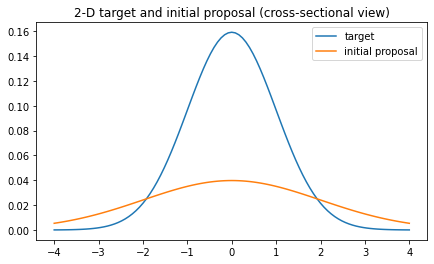

+++++++++++++++++++++++++++++++++++++++++++++++++++++++
IS est: 1.0006; err: 0.0006; a-var: 4.2202; a-err: 0.0021; ESS: 191754
------------ pdf ratio at origin: 16.00 ------------


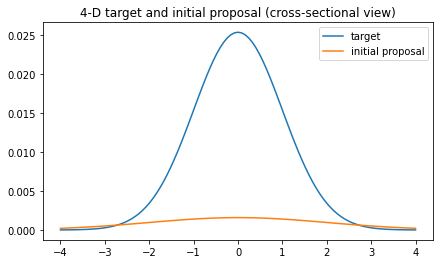

+++++++++++++++++++++++++++++++++++++++++++++++++++++++
IS est: 0.9988; err: 0.0012; a-var: 26.3356; a-err: 0.0051; ESS: 36498
------------ pdf ratio at origin: 256.00 ------------


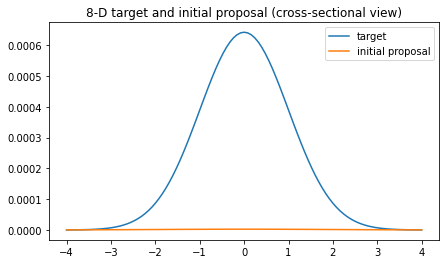

In [3]:
mle=MLE(dim=2,sigma=2)
size=1000000
mle.estimate_IS(size)
x=np.linspace(-4,4,101)
mle.draw_TP(mle.iP,x,'initial')

print('=======================================================')
print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print('=======================================================')

mle=MLE(dim=4,sigma=2)
mle.estimate_IS(size)
mle.draw_TP(mle.iP,x,'initial')

print('=======================================================')
print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print('=======================================================')

mle=MLE(dim=8,sigma=2)
mle.estimate_IS(size)
mle.draw_TP(mle.iP,x,'initial')

**Summary:**
* The cumulative phenomenon of scale difference of all dimension. 

**Future:**
* What about the comparison between multi-normal and multi-t? 

## KDE with different initial proposal and bandwidth in 6-dimension

IS est: 1.0000; err: 0.0000; a-var: 0.0000; a-err: 0.0000; ESS: 50000
------------ pdf ratio at origin: 1.00 ------------


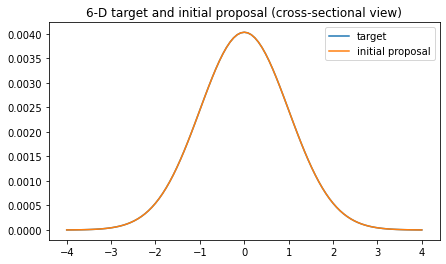

resample rate: 968/1000
bdwth: 0.7112 (based on scott)
NIS est: 1.0043; err: 0.0043; a-var: 0.5006; a-err: 0.0032; ESS: 33416
MIS est: 0.9996; err: 0.0004; a-var: 0.3878; a-err: 0.0028; ESS: 36018
------------ pdf ratio at origin: 3.43 ------------


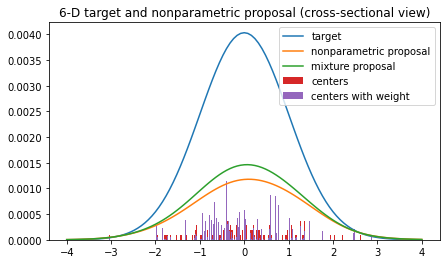

+++++++++++++++++++++++++++++++++++++++++++++++++++++++
IS est: 0.9887; err: 0.0113; a-var: 10.9593; a-err: 0.0148; ESS: 4094
------------ pdf ratio at origin: 64.00 ------------


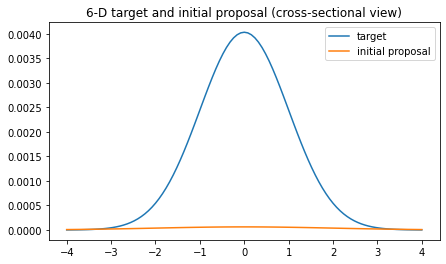

resample rate: 771/1000
bdwth: 0.6959 (based on scott)
NIS est: 0.9992; err: 0.0008; a-var: 0.4291; a-err: 0.0029; ESS: 34970
MIS est: 0.9999; err: 0.0001; a-var: 0.5573; a-err: 0.0033; ESS: 32106
------------ pdf ratio at origin: 3.28 ------------


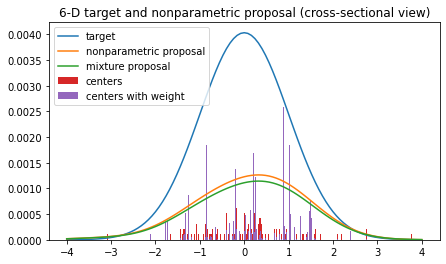

In [4]:
np.random.seed(1234)
mle=MLE(dim=6,sigma=1)
size=50000
mle.estimate_IS(size)
x=np.linspace(-4,4,101)
mle.draw_TP(mle.iP,x,'initial')
print('=======================================================')
mle.resample(1000,20)
mle.estimate_NIS(size,0.9)
mle.draw_TP(mle.nP,x,'nonparametric')

print('=======================================================')
print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print('=======================================================')

np.random.seed(1234)
mle=MLE(dim=6,sigma=2)
mle.estimate_IS(size)
mle.draw_TP(mle.iP,x,'initial')
print('=======================================================')
mle.resample(1000,20)
np.random.seed(123456)
mle.estimate_NIS(size,0.9)
mle.draw_TP(mle.nP,x,'nonparametric')

NIS est: 0.9986; err: 0.0014; a-var: 0.3562; a-err: 0.0027; ESS: 36840
MIS est: 1.0006; err: 0.0006; a-var: 0.4574; a-err: 0.0030; ESS: 34322
------------ pdf ratio at origin: 2.70 ------------


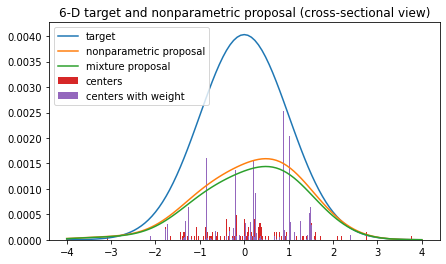

+++++++++++++++++++++++++++++++++++++++++++++++++++++++
NIS est: 0.9958; err: 0.0042; a-var: 0.5727; a-err: 0.0034; ESS: 31695
MIS est: 1.0019; err: 0.0019; a-var: 0.5562; a-err: 0.0033; ESS: 32172
------------ pdf ratio at origin: 2.44 ------------


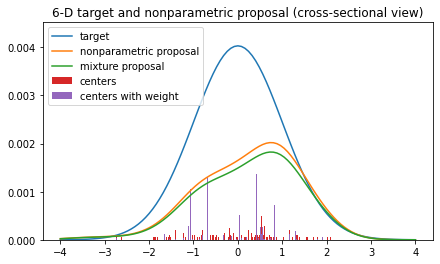

+++++++++++++++++++++++++++++++++++++++++++++++++++++++
NIS est: 0.9853; err: 0.0147; a-var: 2.7418; a-err: 0.0074; ESS: 13075
MIS est: 1.0017; err: 0.0017; a-var: 1.3382; a-err: 0.0052; ESS: 21426
------------ pdf ratio at origin: 2.88 ------------


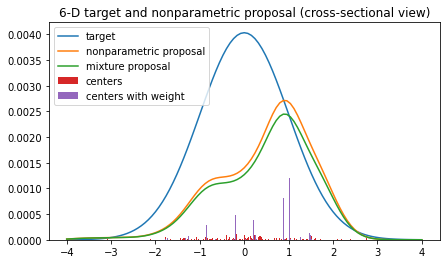

+++++++++++++++++++++++++++++++++++++++++++++++++++++++
NIS est: 0.9853; err: 0.0147; a-var: 2.7418; a-err: 0.0074; ESS: 13075
MIS est: 0.9963; err: 0.0037; a-var: 1.2414; a-err: 0.0050; ESS: 22216
------------ pdf ratio at origin: 2.88 ------------


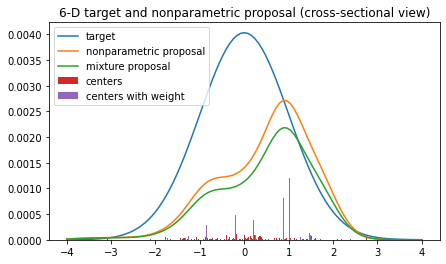

In [5]:
np.random.seed(123456)
mle.estimate_NIS(size,0.9,0.6)
mle.draw_TP(mle.nP,x,'nonparametric')

print('=======================================================')
print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print('=======================================================')

np.random.seed(123456)
mle.estimate_NIS(size,0.9,0.5)
mle.draw_TP(mle.nP,x,'nonparametric')

print('=======================================================')
print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print('=======================================================')

np.random.seed(123456)
mle.estimate_NIS(size,0.9,0.4)
mle.draw_TP(mle.nP,x,'nonparametric')

print('=======================================================')
print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print('=======================================================')

np.random.seed(123456)
mle.estimate_NIS(size,0.8,0.4)
mle.draw_TP(mle.nP,x,'nonparametric')

**Summary:**
* Resampling with ratio 20:1 can give us good pseudo samples from the target. 
* Only conservative bandwidth can work well in higher dimension, because little bandwidth can raise serious tail problem. 

**Future**
* What about KDE with weights? 
* What about the adaptive bandwidth? 

## Regression performance visualization

IS est: 0.9887; err: 0.0113; a-var: 6.9897; a-err: 0.0187; ESS: 2454
------------ pdf ratio at origin: 32.00 ------------


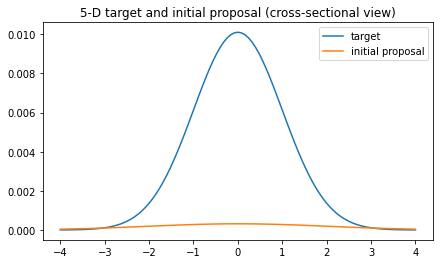

resample rate: 162/200
bdwth: 0.6959 (based on scott)
NIS est: 1.0060; err: 0.0060; a-var: 0.3617; a-err: 0.0043; ESS: 14735
MIS est: 0.9979; err: 0.0021; a-var: 0.4495; a-err: 0.0047; ESS: 13780
------------ pdf ratio at origin: 2.14 ------------


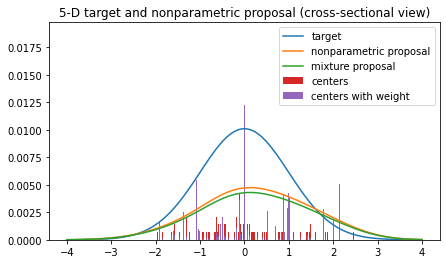

Ordinary R2: 0.8864; Lasso R2: 0.8109
RIS(Ord) est: 1.0003; err: 0.0003; a-var: 0.0511; a-err: 0.0016; ESS: 19029
RIS(Las) est: 0.9997; err: 0.0003; a-var: 0.0850; a-err: 0.0021; ESS: 18433
------------ pdf ratio at origin: 2.36 ------------
regression ratios: ordinary 0.9528, lasso 0.9925


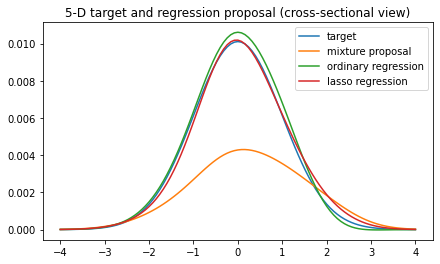

In [6]:
mle=MLE(dim=5,sigma=2)
size=20000
mle.estimate_IS(size)
x=np.linspace(-4,4,101)
mle.draw_TP(mle.iP,x,'initial')
print('=======================================================')
mle.resample(200,20)
mle.estimate_NIS(size,0.9)
mle.draw_TP(mle.nP,x,'nonparametric')
print('=======================================================')
mle.estimate_RIS(0.1)
mle.draw_TP(mle.mP,x,'regression')

## MLE method investigation

IS est: 0.9908; err: 0.0092; a-var: 15.3033; a-err: 0.0277; ESS: 1206
------------ pdf ratio at origin: 128.00 ------------


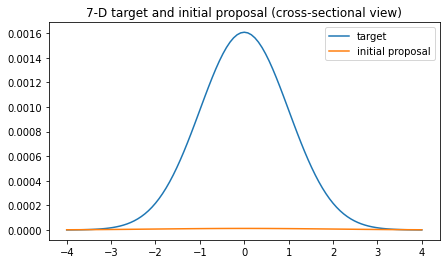

resample rate: 139/200
bdwth: 0.7902 (based on scott)
NIS est: 1.0001; err: 0.0001; a-var: 1.1217; a-err: 0.0075; ESS: 9428
MIS est: 1.0086; err: 0.0086; a-var: 1.3463; a-err: 0.0082; ESS: 8608
------------ pdf ratio at origin: 4.72 ------------


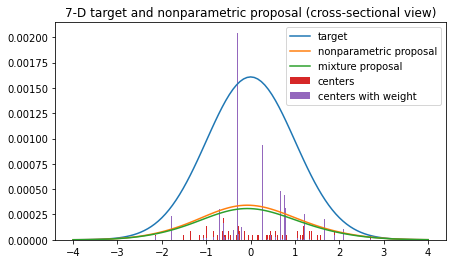

Ordinary R2: 0.7130; Lasso R2: 0.6889
RIS(Ord) est: 1.0101; err: 0.0101; a-var: 0.3864; a-err: 0.0044; ESS: 14506
RIS(Las) est: 1.0111; err: 0.0111; a-var: 0.4188; a-err: 0.0046; ESS: 14188
------------ pdf ratio at origin: 5.22 ------------
regression ratios: ordinary 1.0398, lasso 1.1667


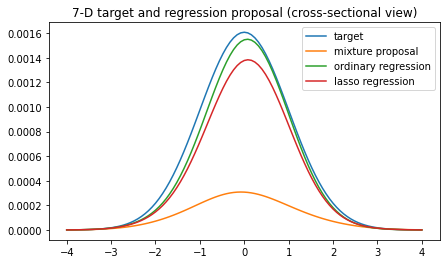

Reference:
origin: value: 11.8351; grad: (min -0.1980, mean -0.0061, max 0.1293, std 0.0591)

Theoretical results:
MLE(The) zeta: (min -0.0036, mean -0.0000, max 0.0041, std 0.0012, norm 0.0137)
theory: value: 11.8318; grad: (min -0.0424, mean -0.0046, max 0.0027, std 0.0079)
RIS(The) est: 1.0101; err: 0.0101
MLE(The) est: 1.0071; err: 0.0071

Optimization results:
MLE nit: 32, spent 10 seconds! 
MLE(Opt) zeta: (min -0.0037, mean 0.0000, max 0.0046, std 0.0012, norm 0.0141)
Dist(zeta(Opt),zeta(The))=0.0021
optimal: value: 11.8317; grad: (min -0.0000, mean -0.0000, max 0.0000, std 0.0000)
MLE(Opt) est: 1.0096; err: 0.0096


In [7]:
mle=MLE(dim=7,sigma=2)
size=20000
mle.estimate_IS(size)
x=np.linspace(-4,4,101)
mle.draw_TP(mle.iP,x,'initial')
print('=======================================================')
mle.resample(200,20)
mle.estimate_NIS(size,0.9)
mle.draw_TP(mle.nP,x,'nonparametric')
print('=======================================================')
mle.estimate_RIS(0.1)
mle.draw_TP(mle.mP,x,'regression')
print('=======================================================')
mle.estimate_MLE(True)